# Fairness Analysis Using AIF360
The purpose of this notebook is to audit the ADS by analyzing how this system treats different sexes. We then check a pre-processing technique to try and improve any unfairness found in the model.

In [1]:
#install packages
!pip install numba==0.48
!pip install aif360==0.3.0rc0
!pip install BlackBoxAuditing

In [2]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import BlackBoxAuditing

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from google.colab import files
import io

%matplotlib inline

Matplotlib Error, comment out matplotlib.use('TkAgg')


## Loading and Splitting Data

In [3]:
#read in the dataset
  # be sure to have the file saved locally and manually select 'heart.csv'
uploaded = files.upload()

heart = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
heart.head()

Saving heart.csv to heart (2).csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
#split data into X and y and scale the X
X = heart[list(heart.columns)[0:-1]]
y = heart['target']

#scale the data in the same manner as the ADS
X_norm = normalize(X, norm='l2')

In [5]:
#split the dataset into train, val, test using the same seeds as the ADS
X_train, X_hold, y_train, y_hold = train_test_split(X_norm, y, test_size=0.33, random_state=101) 
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=42)

## AIF360 Fairness Metrics (Author's Test Data Set)

####Format data

Please note, that by normalizing in the manner the ADS owner did, this changes the input space of the feature sex. We need to map this new column back to a binary 0/1 feature in order to use the AIF360 Binary Label Dataset.

In [6]:
#save datasets at BinaryLabelDatasets

#join X and y data together into an array
train_arr = np.hstack((X_train, y_train.to_numpy().reshape(-1,1)))
val_arr = np.hstack((X_val, y_val.to_numpy().reshape(-1,1)))
test_arr = np.hstack((X_test, y_test.to_numpy().reshape(-1,1)))

#convert back into dataframe
train_df = pd.DataFrame(data=train_arr, columns=heart.columns)
val_df = pd.DataFrame(data=val_arr, columns=heart.columns)
test_df = pd.DataFrame(data=test_arr, columns=heart.columns)

#make sure sex remains binary (this was undone with scaling but 0s remained 0)
train_df.loc[train_df.sex != 0, 'sex'] = 1
val_df.loc[val_df.sex != 0, 'sex'] = 1
test_df.loc[test_df.sex != 0, 'sex'] = 1

#convert sex and target back to int
test_df.sex = test_df.sex.astype(int)
test_df.target = test_df.target.astype(int)

val_df.sex = val_df.sex.astype(int)
val_df.target = val_df.target.astype(int)

train_df.sex = train_df.sex.astype(int)
train_df.target = train_df.target.astype(int)

####Convert in to aif360 Objects

In [7]:
#generate binary label datasets for each of the datasets with the truth value for the target
heart_train_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=train_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

heart_val_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=val_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

heart_test_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=test_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

#save copies of these datasets in order to swap in predictions
heart_train_dataset_preds = heart_train_dataset_truth.copy()
heart_val_dataset_preds = heart_val_dataset_truth.copy()
heart_test_dataset_preds = heart_test_dataset_truth.copy()

####Fit Model

In [8]:
#run this model matching ADS params
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model.fit(X_train, y_train)

#confirm same prediction scores as ADS
print('Score on Validation Set:',model.score(X_val, y_val))
print('Score on Test Set:',model.score(X_test, y_test))

#save preditions on test data
y_preds = model.predict(X_test)

Score on Validation Set: 0.78
Score on Test Set: 0.92


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### Check Fairness Metrics

In [9]:
#save predictions into the dataset
heart_test_dataset_preds.labels = y_preds.reshape(-1,1)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#get classification metrics on test data
metrics = ClassificationMetric(heart_test_dataset_truth, heart_test_dataset_preds,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

In [10]:
#print comparison metrics
print("Overall Test Accuracy:", metrics.accuracy())
print("Male Test Accuracy:", round(metrics.accuracy(privileged=True),3))
print("Female Test Accuracy:", round(metrics.accuracy(privileged=False),3))
print('')
print("Test FPR:", round(metrics.false_positive_rate(),3))
print("Test FPR Difference:", round(metrics.false_positive_rate_difference(),3))
print("")
print("Test FNR:", metrics.false_negative_rate())
print("Test FNR Difference:", metrics.false_negative_rate_difference())
print('')
print("Test Disparate Impact:", round(metrics.disparate_impact(),3))
print('')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_preds))

Overall Test Accuracy: 0.92
Male Test Accuracy: 0.917
Female Test Accuracy: 0.929

Test FPR: 0.154
Test FPR Difference: 0.203

Test FNR: 0.0
Test FNR Difference: 0.0

Test Disparate Impact: 1.929

Confusion Matrix:
[[22  4]
 [ 0 24]]


- $\text{Disparate Impact}=\frac{\mathbb{P}(targ=1|sex=0)}{\mathbb{P}(targ=1|sex=1)}$
- Disparate Impact >1 implies "favorable" outcomes for women
  - But in this case, "favorable" means more likely to be diagnosed with heart disease
  - So we see our model is more likely classify women with a positive diagnosis than men

##AIF360 Fairness Metrics (Larger Test Set)

We noticed that the author of this model leaves the validation set completely unused. We take advantage of this and use the extra data for a more stable evaluation of the model. So we append the valitation data to the test data and use the aggregate set for our evaluations.

####Format Data
Combine test and val data into hold data

In [11]:
#use the intermediate held out dataset (test+val) in one dataset
#take the same steps before to get this into a BinLib set
hold_arr = np.hstack((X_hold, y_hold.to_numpy().reshape(-1,1)))

#convert back into dataframe
hold_df = pd.DataFrame(data=hold_arr, columns=heart.columns)
#make sure sex remains binary (this was undone with scaling but 0s remained 0)
hold_df.loc[hold_df.sex != 0, 'sex'] = 1
#convert sex and target back to int
hold_df.sex = hold_df.sex.astype(int)
hold_df.target = hold_df.target.astype(int)

heart_hold_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=hold_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

heart_hold_dataset_preds = heart_hold_dataset_truth.copy()
y_preds_new = model.predict(X_hold)

heart_hold_dataset_preds.labels = y_preds_new.reshape(-1,1)

####Convert into air360 Objects

In [12]:
#get classification metrics on bigger test data
metrics_new = ClassificationMetric(heart_hold_dataset_truth, heart_hold_dataset_preds,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

####Print Metrics

In [13]:
#print comparizon metrics
print("Overall Combined Test Accuracy:", metrics_new.accuracy())
print("Male Combined Test Accuracy:", round(metrics_new.accuracy(privileged=True),3))
print("Female Combined Test Accuracy:", round(metrics_new.accuracy(privileged=False),3))
print('')
print("Combined Test FPR:", round(metrics_new.false_positive_rate(),3))
print("Combined Test FPR Difference:", round(metrics_new.false_positive_rate_difference(),3))
print("")
print("Combined Test FNR:", round(metrics_new.false_negative_rate(),3))
print("Combined Test FNR Difference:", round(metrics_new.false_negative_rate_difference(),3))
print('')
print("Combined Test Disparate Impact:", round(metrics_new.disparate_impact(),3))
print('')
print("Combined Confusion Matrix:")
print(confusion_matrix(y_hold, y_preds_new))

Overall Combined Test Accuracy: 0.85
Male Combined Test Accuracy: 0.822
Female Combined Test Accuracy: 0.926

Combined Test FPR: 0.208
Combined Test FPR Difference: 0.045

Combined Test FNR: 0.096
Combined Test FNR Difference: -0.094

Combined Test Disparate Impact: 1.829

Combined Confusion Matrix:
[[38 10]
 [ 5 47]]


####Plot Metrics
To ensure we can use the same y-axes for all three plots below, we use precision (1-FPR) and recall (1-FNR)

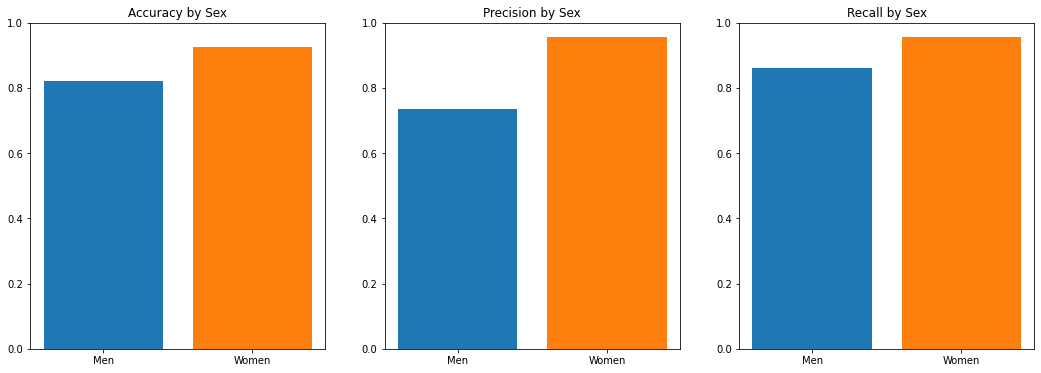

In [14]:
#3 plots -- acc, fpr, fnr
labs = ['Men','Women']
colors = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].bar(labs, [metrics_new.accuracy(privileged=True), metrics_new.accuracy(privileged=False)],
          color=colors)
ax[1].bar(labs, [metrics_new.precision(privileged=True),
                 metrics_new.precision(privileged=False)], color=colors)
ax[2].bar(labs, [metrics_new.recall(privileged=True), 
                 metrics_new.recall(privileged=False)], color=colors)

ax[0].set_title('Accuracy by Sex')
ax[1].set_title('Precision by Sex')
ax[2].set_title('Recall by Sex')

for i in range(3):
  ax[i].set_ylim(0,1)

plt.show()

##DisparateImpactRemover Implementation
Here we impleent a simple disparate impact remover algorimth in preprocessing too see how both disparities between the sexes and overall accuracy and recall are affected.

####Format data and Train DI Remover

In [15]:
#intiates disparate impact repair on data sets
DIR = DisparateImpactRemover(repair_level=1)
train_DIR = DIR.fit_transform(heart_train_dataset_truth)
val_DIR = DIR.fit_transform(heart_val_dataset_truth)
test_DIR = DIR.fit_transform(heart_test_dataset_truth)
hold_DIR = DIR.fit_transform(heart_hold_dataset_truth)

#save copies of these datasets in order to swap in predictions
train_DIR_preds = train_DIR.copy()
val_DIR_preds = val_DIR.copy()
test_DIR_preds = test_DIR.copy()
hold_DIR_preds = hold_DIR.copy()

feature_names = train_DIR.feature_names + ['target']

rep_train_pd = pd.DataFrame(np.hstack([train_DIR.features,train_DIR.labels]),columns=feature_names)
rep_val_pd = pd.DataFrame(np.hstack([val_DIR.features,val_DIR.labels]),columns=feature_names)
rep_test_pd = pd.DataFrame(np.hstack([test_DIR.features,test_DIR.labels]),columns=feature_names)
rep_hold_pd = pd.DataFrame(np.hstack([hold_DIR.features,hold_DIR.labels]),columns=feature_names)

#features
X_train_rep = rep_train_pd[feature_names[:-1]]
X_val_rep = rep_val_pd[feature_names[:-1]]
X_test_rep = rep_test_pd[feature_names[:-1]]
X_hold_rep = rep_hold_pd[feature_names[:-1]]

#labels
y_train_rep = rep_train_pd[feature_names[-1]]
y_val_rep = rep_val_pd[feature_names[-1]]
y_test_rep = rep_test_pd[feature_names[-1]]
y_hold_rep = rep_hold_pd[feature_names[-1]]

####Train Model

In [16]:
model_rep = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)

model_rep.fit(X_train_rep,y_train_rep)
#confirm same prediction scores as ADS
print('Hold score:',model_rep.score(X_hold_rep, y_hold_rep))

#save preditions on test data
y_preds_rep = model_rep.predict(X_hold_rep)

Hold score: 0.83


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


####Print Metrics

In [17]:
#save predictions into the dataset
hold_DIR_preds.labels = y_preds_rep.reshape(-1,1)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#get classification metrics on test data
metrics_rep = ClassificationMetric(hold_DIR, hold_DIR_preds,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

In [18]:
#print comparizon metrics
print("Overall Combined Test Accuracy:", metrics_rep.accuracy())
print("Male Combined Test Accuracy:", metrics_rep.accuracy(privileged=True))
print("Female Combined Test Accuracy:", metrics_rep.accuracy(privileged=False))
print('')
print("Combined Test FPR:", metrics_rep.false_positive_rate())
print("Combined Test FPR Difference:", metrics_rep.false_positive_rate_difference())
print("")
print("Combined Test FNR:", metrics_rep.false_negative_rate())
print("Combined Test FNR Difference:", metrics_rep.false_negative_rate_difference())
print('')
print("Combined Test Disparate Impact:", metrics_rep.disparate_impact())
print('')
print("Combined Confusion Matrix:")
print(confusion_matrix(y_hold_rep, y_preds_rep))

Overall Combined Test Accuracy: 0.83
Male Combined Test Accuracy: 0.7945205479452054
Female Combined Test Accuracy: 0.9259259259259259

Combined Test FPR: 0.2708333333333333
Combined Test FPR Difference: -0.022727272727272707

Combined Test FNR: 0.07692307692307693
Combined Test FNR Difference: -0.05997001499250375

Combined Test Disparate Impact: 1.6364522417153997

Combined Confusion Matrix:
[[35 13]
 [ 4 48]]


####Plot Metrics

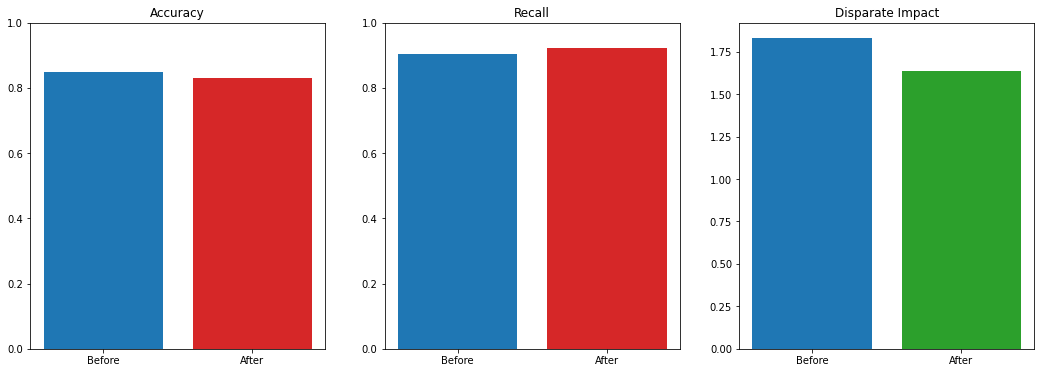

In [19]:
#3 plots -- acc, fpr, fnr
labs = ['Before','After']
colors_good = ['tab:blue', 'tab:green']
colors_bad = ['tab:blue', 'tab:red']

fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].bar(labs, [metrics_new.accuracy(), metrics_rep.accuracy()], color=colors_bad)
ax[1].bar(labs, [metrics_new.recall(), metrics_rep.recall()], color=colors_bad)
ax[2].bar(labs, [metrics_new.disparate_impact(), metrics_rep.disparate_impact()], color=colors_good)

ax[0].set_title('Accuracy')
ax[1].set_title('Recall')
ax[2].set_title('Disparate Impact')


for i in range(2):
  ax[i].set_ylim(0,1)

plt.show()

In these plots, we see that while disparate impact is slightly improved, this comes at the cost of both recall and accuracy. As we discuss in the write up, due to the life and death nature of a heart disease diagnosis, we argue against using this preprocessing technique in a real world setting.